***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#6' style="text-decoration : none; color : #000000;">5. Comparing Results</a></h2>  
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [11]:
df=pd.read_csv('Html.csv')
df.drop(['Unnamed: 0','Malicious'],axis=1,inplace=True)

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_absolute,a_href_ftp,a_href_http,a_href_https,a_href_irc,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,...,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,progress_count,q_count,s_count,samp_count,script_async

Shape of our dataset: (43491, 1461)


#### Let us analyze the balance of classes

In [12]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [13]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        print(col)
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1461)


In [14]:
# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: Series([], dtype: object)


#### Check for missing data

In [15]:
df.isnull().sum()

a_charset_utf-8                                          0
a_count                                                  0
a_download_download                                      0
a_hidden_true                                            0
a_href_.7z                                               0
a_href_.apk                                              0
a_href_.app                                              0
a_href_.asp                                              0
a_href_.aspx                                             0
a_href_.au                                               0
a_href_.avi                                              0
a_href_.b                                                0
a_href_.bin                                              0
a_href_.br                                               0
a_href_.bz2                                              0
a_href_.ca                                               0
a_href_.cat                                             

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [16]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

1297 columns have more than 95% same values


In [17]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [18]:
columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()+['Target']

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [19]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_absolute,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [20]:
columns.remove('Target')
print("Features we will be using:")
columns=num_stats_js[0:50].index.values
display(columns.tolist())

Features we will be using:


['script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_relative',
 'a_href_absolute',
 'a_href_out_of_domain',
 'img_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_https',
 'img_src_relative',
 'img_src_absolute',
 'img_src_https',
 'iframe_src_absolute',
 'iframe_src_relative',
 'link_rel_shortcut icon',
 'iframe_src_https',
 'a_href_https',
 'link_href_.ico',
 'link_count',
 'link_href_relative',
 'link_href_absolute',
 'link_rel_stylesheet',
 'img_src_.jpg',
 'link_rel_icon',
 'img_src_out_of_domain',
 'link_href_.png',
 'link_href_.css',
 'ul_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_image/x-icon',
 'link_rel_manifest',
 'iframe_src_.html',
 'span_count',
 'iframe_src_out_of_domain',
 'form_action_relative',
 'img_src_.png',
 'form_action_absolute',


In [21]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [22]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [23]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.889629799954
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26291  3411    29702
True         429  4661     5090
__all__    26720  8072    34792

Accuracy of the KNN model for twst data is: 0.89010231061
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6581   831     7412
True         125  1162     1287
__all__     6706  1993     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.852437341918
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29592   110    29702
True        5024    66     5090
__all__    34616   176    34792

Accuracy of the Logistic Regression model for twst data is: 0.850557535349
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7383    29     7412
True        1271    16     1287
__all__     8654    45     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.900753046677
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26375  3327    29702
True         126  4964     5090
__all__    26501  8291    34792

Accuracy of the Random Forest Classifier for twst data is: 0.891596735257
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6591   821     7412
True         122  1165     1287
__all__     6713  1986     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.872269487238
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25982  3720    29702
True         724  4366     5090
__all__    26706  8086    34792

Accuracy of the Ada Boost Classifier for twst data is: 0.871594436142
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6497   915     7412
True         202  1085     1287
__all__     6699  2000     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.888422625891
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26340  3362    29702
True         520  4570     5090
__all__    26860  7932    34792

Accuracy of the Gradient Boosting Classifier for twst data is: 0.886193815381
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6583   829     7412
True         161  1126     1287
__all__     6744  1955     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.90267877673
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26384  3318    29702
True          68  5022     5090
__all__    26452  8340    34792

Accuracy of the Extra Tree Classifier for twst data is: 0.892056558225
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6590   822     7412
True         117  1170     1287
__all__     6707  1992     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.900954242355
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26373  3329    29702
True         117  4973     5090
__all__    26490  8302    34792

Accuracy of the Bagging model for twst data is: 0.891481779515
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6577   835     7412
True         109  1178     1287
__all__     6686  2013     8699



Neural Network-1
The accuracy of the model on training data is: 0.889371119798


Predicted  False  True  __all__
Actual                         
False      26035  3667    29702
True         182  4908     5090
__all__    26217  8575    34792

The accuracy of the model on test data is: 0.877802046212


Predicted  False  True  __all__
Actual                         
False       6458   954     7412
True         109  1178     1287
__all__     6567  2132     8699

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.889630,4661.0,26291.0,3411.0,429.0,0.114841,0.084283
LogisticRegression,0.852437,66.0,29592.0,110.0,5024.0,0.003703,0.987033
RandomForestClassifier,0.900753,4964.0,26375.0,3327.0,126.0,0.112013,0.024754
AdaBoostClassifier,0.872269,4366.0,25982.0,3720.0,724.0,0.125244,0.142240
GradientBoostingClassifier,0.888423,4570.0,26340.0,3362.0,520.0,0.113191,0.102161
ExtraTreeClassifier,0.902679,5022.0,26384.0,3318.0,68.0,0.111710,0.013360
BaggingClassifier,0.900954,4973.0,26373.0,3329.0,117.0,0.112080,0.022986
Neural Network-1,0.889371,4908.0,26035.0,3667.0,182.0,0.123460,0.035756


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.890102,1162.0,6581.0,831.0,125.0,0.112115,0.097125,0.895380
LogisticRegression,0.850558,16.0,7383.0,29.0,1271.0,0.003913,0.987568,0.504260
RandomForestClassifier,0.891597,1165.0,6591.0,821.0,122.0,0.110766,0.094794,0.897220
AdaBoostClassifier,0.871594,1085.0,6497.0,915.0,202.0,0.123448,0.156954,0.859799
GradientBoostingClassifier,0.886194,1126.0,6583.0,829.0,161.0,0.111846,0.125097,0.881529
ExtraTreeClassifier,0.892057,1170.0,6590.0,822.0,117.0,0.110901,0.090909,0.899095
BaggingClassifier,0.891482,1178.0,6577.0,835.0,109.0,0.112655,0.084693,0.901326
Neural Network-1,0.877802,1178.0,6458.0,954.0,109.0,0.128710,0.084693,0.901326


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [29]:
df.reset_index(inplace=True)

columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [30]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 43491, Columns: 51]
  Relationships:
    No relationships

In [31]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 8.372 seconds
Elapsed: 01:06 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [32]:
feature_matrix_sessions.head()

,script_src_.js,script_count,script_src_relative,script_src_absolute,script_src_https,script_async_true,link_rel_canonical,div_count,script_type_text/javascript,script_src_out_of_domain,iframe_count,a_count,a_href_relative,a_href_absolute,a_href_out_of_domain,img_count,meta_http-equiv_X-UA-Compatible,link_href_https,img_src_relative,img_src_absolute,img_src_https,iframe_src_absolute,iframe_src_relative,link_rel_shortcut icon,iframe_src_https,a_href_https,link_href_.ico,link_count,link_href_relative,link_href_absolute,link_rel_stylesheet,img_src_.jpg,link_rel_icon,img_src_out_of_domain,link_href_.png,link_href_.css,ul_count,li_count,link_href_out_of_domain,link_type_image/x-icon,link_rel_manifest,iframe_src_.html,span_count,iframe_src_out_of_domain,form_action_relative,img_src_.png,form_action_absolute,link_type_text/css,link_rel_apple-touch-icon,link_type_image/png,img_src_https + link_href_absolute,iframe_src_.html + li_count,link_rel_shortcut icon + script_src_https,img_src_absolute + ul_count,img_src_https + span_count,link_rel_apple-touch-icon + meta_http-equiv_X-UA-Compatible,link_count + span_count,iframe_src_relative + img_src_relative,form_action_relative + link_type_text/css,form_action_absolute + link_count,a_count + iframe_src_relative,a_href_absolute + link_rel_apple-touch-icon,iframe_src_out_of_domain + meta_http-equiv_X-UA-Compatible,iframe_src_relative + li_count,link_href_https + script_src_https,img_count + link_count,link_href_https + link_rel_stylesheet,img_src_relative + link_href_.ico,link_type_image/png + script_type_text/javascript,iframe_count + img_src_absolute,img_src_out_of_domain + link_href_https,link_href_out_of_domain + script_src_https,img_src_absolute + meta_http-equiv_X-UA-Compatible,link_href_out_of_domain + link_rel_shortcut icon,img_src_out_of_domain + link_href_relative,iframe_src_absolute + link_type_text/css,link_rel_manifest + script_src_absolute,a_href_out_of_domain + iframe_src_absolute,img_src_.jpg + link_type_text/css,a_href_relative + link_rel_apple-touch-icon,script_src_.js + script_src_https,li_count + script_src_out_of_domain,link_href_absolute + script_type_text/javascript,img_src_.jpg + link_href_absolute,link_href_.css + link_rel_stylesheet,img_count + img_src_out_of_domain,link_href_https + script_async_true,img_src_.png + li_count,link_href_.png + script_src_relative,a_href_out_of_domain + img_src_.png,a_href_absolute + link_href_relative,link_href_https + link_type_image/x-icon,iframe_src_out_of_domain + script_count,img_count + link_href_https,script_src_out_of_domain + ul_count,iframe_src_absolute + img_src_.png,img_src_relative + script_src_.js,a_href_relative + img_count,iframe_src_absolute + span_count,link_href_relative + script_src_.js,link_href_https + script_count,form_action_absolute + link_href_.css,iframe_src_out_of_domain + link_href_.png,link_rel_apple-touch-icon + script_count,link_count + link_href_.png,link_href_.png + script_src_https,script_count + script_type_text/javascript,a_href_relative + img_src_.png,form_action_relative + link_href_absolute,link_href_relative + span_count,iframe_src_https + script_src_https,img_src_https + script_src_absolute,a_href_https + span_count,link_count + script_count,link_type_image/x-icon + meta_http-equiv_X-UA-Compatible,form_action_relative + span_count,a_href_https + link_count,link_type_image/png + script_src_absolute,link_type_image/png + script_count,script_src_absolute + script_src_out_of_domain,img_src_https + link_count,div_count + li_count,iframe_src_relative + img_src_absolute,a_href_relative + link_href_relative,link_count + script_src_out_of_domain,script_src_relative + script_type_text/javascript,img_src_.jpg + link_rel_canonical,img_src_relative + link_count,a_href_out_of_domain + meta_http-equiv_X-UA-Compatible,link_rel_stylesheet + script_count,a_href_out_of_domain + link_rel_apple-touch-icon,a_count + img_src_https,a_href_relative + link_rel_shortcut icon,link_rel_canonical + script_src_absolute,form_a

In [33]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [34]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [35]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [36]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [37]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [38]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [39]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [44]:
X=fs[feature_selection_df[feature_selection_df.Total>=2]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43491, 62)

In [45]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['link_href_out_of_domain / link_count',
 'script_src_relative / script_src_absolute',
 'script_src_.js / script_count',
 'script_async_true / script_count',
 'script_type_text/javascript / script_count',
 'script_src_relative / script_count',
 'script_src_out_of_domain / script_src_relative',
 'script_src_out_of_domain / script_src_absolute',
 'script_src_out_of_domain / script_count',
 'script_src_https / script_src_relative',
 'script_src_https / script_src_absolute',
 'script_src_https / script_count',
 'script_src_absolute / script_src_relative',
 'script_src_absolute / script_count',
 'script_src_.js / script_src_relative',
 'script_src_.js / script_src_absolute',
 'script_count / script_src_absolute',
 'script_count + script_src_.js',
 'link_rel_shortcut icon + meta_http-equiv_X-UA-Compatible',
 'link_rel_manifest + meta_http-equiv_X-UA-Compatible',
 'link_rel_canonical / meta_http-equiv_X-UA-Compatible',
 'link_rel_canonical / link_href_.css',
 'link_rel_canonical + meta_http-e

In [46]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [47]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.868446769372
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29542   159    29701
True        4418   673     5091
__all__    33960   832    34792

Accuracy of the KNN model for twst data is: 0.866191516266
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7362    51     7413
True        1113   173     1286
__all__     8475   224     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.877471832605
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26133  3568    29701
True         695  4396     5091
__all__    26828  7964    34792

Accuracy of the Logistic Regression model for twst data is: 0.877457178986
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6547   866     7413
True         200  1086     1286
__all__     6747  1952     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.897907564957
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26288  3413    29701
True         139  4952     5091
__all__    26427  8365    34792

Accuracy of the Random Forest Classifier for twst data is: 0.89010231061
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6563   850     7413
True         106  1180     1286
__all__     6669  2030     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.877471832605
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26081  3620    29701
True         643  4448     5091
__all__    26724  8068    34792

Accuracy of the Ada Boost Classifier for twst data is: 0.879526382343
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6544   869     7413
True         179  1107     1286
__all__     6723  1976     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.885605886411
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26300  3401    29701
True         579  4512     5091
__all__    26879  7913    34792

Accuracy of the Gradient Boosting Classifier for twst data is: 0.883664789056
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6568   845     7413
True         167  1119     1286
__all__     6735  1964     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.899718326052
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26297  3404    29701
True          85  5006     5091
__all__    26382  8410    34792

Accuracy of the Extra Tree Classifier for twst data is: 0.8895275319
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6562   851     7413
True         110  1176     1286
__all__     6672  2027     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.897792595999
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26293  3408    29701
True         148  4943     5091
__all__    26441  8351    34792

Accuracy of the Bagging model for twst data is: 0.889987354868
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6563   850     7413
True         107  1179     1286
__all__     6670  2029     8699



Neural Network-1
The accuracy of the model on training data is: 0.895665670269


Predicted  False  True  __all__
Actual                         
False      26255  3446    29701
True         184  4907     5091
__all__    26439  8353    34792

The accuracy of the model on test data is: 0.885963903897


Predicted  False  True  __all__
Actual                         
False       6527   886     7413
True         106  1180     1286
__all__     6633  2066     8699

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [48]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [49]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.868447,673.0,29542.0,159.0,4418.0,0.005353,0.867806
LogisticRegression,0.877472,4396.0,26133.0,3568.0,695.0,0.120131,0.136515
RandomForestClassifier,0.897908,4952.0,26288.0,3413.0,139.0,0.114912,0.027303
AdaBoostClassifier,0.877472,4448.0,26081.0,3620.0,643.0,0.121881,0.126301
GradientBoostingClassifier,0.885606,4512.0,26300.0,3401.0,579.0,0.114508,0.113730
ExtraTreeClassifier,0.899718,5006.0,26297.0,3404.0,85.0,0.114609,0.016696
BaggingClassifier,0.897793,4943.0,26293.0,3408.0,148.0,0.114744,0.029071
Neural Network-1,0.895666,4907.0,26255.0,3446.0,184.0,0.116023,0.036142


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.866192,173.0,7362.0,51.0,1113.0,0.006880,0.865474,0.563823
LogisticRegression,0.877457,1086.0,6547.0,866.0,200.0,0.116822,0.155521,0.863829
RandomForestClassifier,0.890102,1180.0,6563.0,850.0,106.0,0.114663,0.082426,0.901455
AdaBoostClassifier,0.879526,1107.0,6544.0,869.0,179.0,0.117226,0.139191,0.871791
GradientBoostingClassifier,0.883665,1119.0,6568.0,845.0,167.0,0.113989,0.129860,0.878076
ExtraTreeClassifier,0.889528,1176.0,6562.0,851.0,110.0,0.114798,0.085537,0.899833
BaggingClassifier,0.889987,1179.0,6563.0,850.0,107.0,0.114663,0.083204,0.901066
Neural Network-1,0.885964,1180.0,6527.0,886.0,106.0,0.119520,0.082426,0.901066


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [50]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [52]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

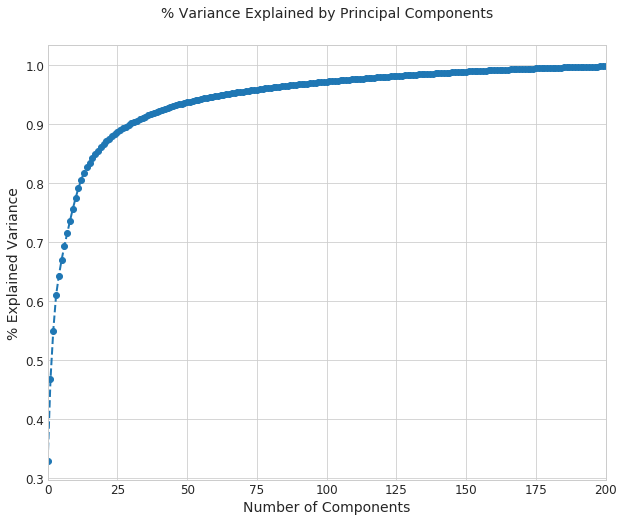

In [53]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [59]:
pca=PCA(n_components=64,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 64 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 64 components is: 0.949870733791


In [60]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [61]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [63]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,64).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.890175902506
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26327  3374    29701
True         447  4644     5091
__all__    26774  8018    34792

Accuracy of the KNN model for twst data is: 0.887918151512
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6565   848     7413
True         127  1159     1286
__all__     6692  2007     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.874568866406
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26086  3615    29701
True         749  4342     5091
__all__    26835  7957    34792

Accuracy of the Logistic Regression model for twst data is: 0.875502931371
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6532   881     7413
True         202  1084     1286
__all__     6734  1965     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.900638077719
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26382  3319    29701
True         138  4953     5091
__all__    26520  8272    34792

Accuracy of the Random Forest Classifier for twst data is: 0.892401425451
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6593   820     7413
True         116  1170     1286
__all__     6709  1990     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.881352034951
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26288  3413    29701
True         715  4376     5091
__all__    27003  7789    34792

Accuracy of the Ada Boost Classifier for twst data is: 0.883549833314
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6584   829     7413
True         184  1102     1286
__all__     6768  1931     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.889773511152
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26404  3297    29701
True         538  4553     5091
__all__    26942  7850    34792

Accuracy of the Gradient Boosting Classifier for twst data is: 0.88837797448
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6594   819     7413
True         152  1134     1286
__all__     6746  1953     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.902650034491
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26386  3315    29701
True          72  5019     5091
__all__    26458  8334    34792

Accuracy of the Extra Tree Classifier for twst data is: 0.893206115645
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6594   819     7413
True         110  1176     1286
__all__     6704  1995     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.900695562198
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26372  3329    29701
True         126  4965     5091
__all__    26498  8294    34792

Accuracy of the Bagging model for twst data is: 0.893091159903
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6588   825     7413
True         105  1181     1286
__all__     6693  2006     8699



Neural Network-1
The accuracy of the model on training data is: 0.896412968499


Predicted  False  True  __all__
Actual                         
False      26192  3509    29701
True          95  4996     5091
__all__    26287  8505    34792

The accuracy of the model on test data is: 0.885733992413


Predicted  False  True  __all__
Actual                         
False       6508   905     7413
True          89  1197     1286
__all__     6597  2102     8699

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [64]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [65]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.890176,4644.0,26327.0,3374.0,447.0,0.113599,0.087802
LogisticRegression,0.874569,4342.0,26086.0,3615.0,749.0,0.121713,0.147122
RandomForestClassifier,0.900638,4953.0,26382.0,3319.0,138.0,0.111747,0.027107
AdaBoostClassifier,0.881352,4376.0,26288.0,3413.0,715.0,0.114912,0.140444
GradientBoostingClassifier,0.889774,4553.0,26404.0,3297.0,538.0,0.111006,0.105677
ExtraTreeClassifier,0.902650,5019.0,26386.0,3315.0,72.0,0.111612,0.014143
BaggingClassifier,0.900696,4965.0,26372.0,3329.0,126.0,0.112084,0.024750
Neural Network-1,0.896413,4996.0,26192.0,3509.0,95.0,0.118144,0.018660


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.887918,1159.0,6565.0,848.0,127.0,0.114394,0.098756,0.893425
LogisticRegression,0.875503,1084.0,6532.0,881.0,202.0,0.118845,0.157076,0.862039
RandomForestClassifier,0.892401,1170.0,6593.0,820.0,116.0,0.110616,0.090202,0.899591
AdaBoostClassifier,0.883550,1102.0,6584.0,829.0,184.0,0.111831,0.143079,0.872545
GradientBoostingClassifier,0.888378,1134.0,6594.0,819.0,152.0,0.110482,0.118196,0.885661
ExtraTreeClassifier,0.893206,1176.0,6594.0,819.0,110.0,0.110482,0.085537,0.901991
BaggingClassifier,0.893091,1181.0,6588.0,825.0,105.0,0.111291,0.081649,0.903530
Neural Network-1,0.885734,1197.0,6508.0,905.0,89.0,0.122083,0.069207,0.903530


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [67]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,64).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [68]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['a_count',
 'a_href_.aspx',
 'a_href_.com',
 'a_href_.htm',
 'a_href_.html',
 'a_href_.pdf',
 'a_href_.php',
 'a_href_0',
 'a_href_absolute',
 'a_href_http',
 'a_href_https',
 'a_href_mailto',
 'a_href_out_of_domain',
 'a_href_relative',
 'a_href_script_javascript',
 'a_rel_nofollow',
 'article_count',
 'aside_count',
 'b_count',
 'base_count',
 'base_href_absolute',
 'base_href_out_of_domain',
 'base_href_relative',
 'br_count',
 'button_count',
 'center_count',
 'dd_count',
 'div_count',
 'dl_count',
 'dt_count',
 'em_count',
 'fieldset_count',
 'figure_count',
 'font_count',
 'footer_count',
 'form_action_.php',
 'form_action_absolute',
 'form_action_http',
 'form_action_https',
 'form_action_out_of_domain',
 'form_action_relative',
 'form_count',
 'form_enctype_application/x-www-form-urlencoded',
 'h1_count',
 'header_count',
 'hr_count',
 'i_count',
 'iframe_count',
 'iframe_sandbox_allow_same_origin_count',
 'iframe_sandbox_allow_scripts_count',
 'iframe_src_.com',
 'iframe_src_

In [69]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [70]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [71]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.926604269073
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26009   3693    29702
True         667  29035    29702
__all__    26676  32728    59404

Accuracy of the KNN model for twst data is: 0.872743993562
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6398  1014     7412
True          93  1194     1287
__all__     6491  2208     8699



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.894333714901
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24784   4918    29702
True        1359  28343    29702
__all__    26143  33261    59404

Accuracy of the Logistic Regression model for twst data is: 0.852396827222
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6195  1217     7412
True          67  1220     1287
__all__     6262  2437     8699



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.94768029089
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26978   2724    29702
True         384  29318    29702
__all__    27362  32042    59404

Accuracy of the Random Forest Classifier for twst data is: 0.907920450627
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6726   686     7412
True         115  1172     1287
__all__     6841  1858     8699



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.908895023904
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25457   4245    29702
True        1167  28535    29702
__all__    26624  32780    59404

Accuracy of the Ada Boost Classifier for twst data is: 0.870789745948
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6360  1052     7412
True          72  1215     1287
__all__     6432  2267     8699



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.925173388997
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26113   3589    29702
True         856  28846    29702
__all__    26969  32435    59404

Accuracy of the Gradient Boosting Classifier for twst data is: 0.889182664674
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6535   877     7412
True          87  1200     1287
__all__     6622  2077     8699



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.948168473503
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26979   2723    29702
True         356  29346    29702
__all__    27335  32069    59404

Accuracy of the Extra Tree Classifier for twst data is: 0.906655937464
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6720   692     7412
True         120  1167     1287
__all__     6840  1859     8699



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.947427782641
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26973   2729    29702
True         394  29308    29702
__all__    27367  32037    59404

Accuracy of the Bagging model for twst data is: 0.907460627658
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6717   695     7412
True         110  1177     1287
__all__     6827  1872     8699



Neural Network-1
The accuracy of the model on training data is: 0.939263349273


Predicted  False   True  __all__
Actual                          
False      26491   3211    29702
True         397  29305    29702
__all__    26888  32516    59404

The accuracy of the model on test data is: 0.887458328544


Predicted  False  True  __all__
Actual                         
False       6530   882     7412
True          97  1190     1287
__all__     6627  2072     8699

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [72]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [73]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.926604,29035.0,26009.0,3693.0,667.0,0.124335,0.022456
LogisticRegression,0.894334,28343.0,24784.0,4918.0,1359.0,0.165578,0.045754
RandomForestClassifier,0.947680,29318.0,26978.0,2724.0,384.0,0.091711,0.012928
AdaBoostClassifier,0.908895,28535.0,25457.0,4245.0,1167.0,0.142920,0.039290
GradientBoostingClassifier,0.925173,28846.0,26113.0,3589.0,856.0,0.120834,0.028820
ExtraTreeClassifier,0.948168,29346.0,26979.0,2723.0,356.0,0.091677,0.011986
BaggingClassifier,0.947428,29308.0,26973.0,2729.0,394.0,0.091879,0.013265
Neural Network-1,0.939263,29305.0,26491.0,3211.0,397.0,0.108107,0.013366


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.872744,1194.0,6398.0,1014.0,93.0,0.136805,0.072261,0.895467
LogisticRegression,0.852397,1220.0,6195.0,1217.0,67.0,0.164193,0.052059,0.891874
RandomForestClassifier,0.907920,1172.0,6726.0,686.0,115.0,0.092553,0.089355,0.909046
AdaBoostClassifier,0.870790,1215.0,6360.0,1052.0,72.0,0.141932,0.055944,0.901062
GradientBoostingClassifier,0.889183,1200.0,6535.0,877.0,87.0,0.118322,0.067599,0.907040
ExtraTreeClassifier,0.906656,1167.0,6720.0,692.0,120.0,0.093362,0.093240,0.906699
BaggingClassifier,0.907461,1177.0,6717.0,695.0,110.0,0.093767,0.085470,0.910382
Neural Network-1,0.887458,1190.0,6530.0,882.0,97.0,0.118996,0.075369,0.910382


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [74]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [75]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12754, 1462)


,index,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_absolute,a_href_ftp,a_href_http,a_href_https,a_href_irc,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,...,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,progress_count,q_count,s_count,samp_count,script_async_true,sc

In [76]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [77]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [78]:
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['a_count',
 'a_href_.aspx',
 'a_href_.com',
 'a_href_.htm',
 'a_href_.html',
 'a_href_.pdf',
 'a_href_.php',
 'a_href_0',
 'a_href_absolute',
 'a_href_http',
 'a_href_https',
 'a_href_mailto',
 'a_href_out_of_domain',
 'a_href_relative',
 'a_href_script_javascript',
 'a_rel_nofollow',
 'article_count',
 'aside_count',
 'b_count',
 'base_count',
 'base_href_absolute',
 'base_href_out_of_domain',
 'base_href_relative',
 'br_count',
 'button_count',
 'center_count',
 'dd_count',
 'div_count',
 'dl_count',
 'dt_count',
 'em_count',
 'fieldset_count',
 'figure_count',
 'font_count',
 'footer_count',
 'form_action_.php',
 'form_action_absolute',
 'form_action_http',
 'form_action_https',
 'form_action_out_of_domain',
 'form_action_relative',
 'form_count',
 'form_enctype_application/x-www-form-urlencoded',
 'h1_count',
 'header_count',
 'hr_count',
 'i_count',
 'iframe_count',
 'iframe_sandbox_allow_same_origin_count',
 'iframe_sandbox_allow_scripts_count',
 'iframe_src_.com',
 'iframe_src_

In [79]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.90953641086
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4494   654     5148
True         269  4786     5055
__all__     4763  5440    10203

Accuracy of the KNN model for twst data is: 0.897295178361
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1058   171     1229
True          91  1231     1322
__all__     1149  1402     2551



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.892874644712
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4295   853     5148
True         240  4815     5055
__all__     4535  5668    10203

Accuracy of the Logistic Regression model for twst data is: 0.901607212858
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1043   186     1229
True          65  1257     1322
__all__     1108  1443     2551



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.945996275605
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4671   477     5148
True          74  4981     5055
__all__     4745  5458    10203

Accuracy of the Random Forest Classifier for twst data is: 0.918071344571
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1113   116     1229
True          93  1229     1322
__all__     1206  1345     2551



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.896108987553
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4349   799     5148
True         261  4794     5055
__all__     4610  5593    10203

Accuracy of the Ada Boost Classifier for twst data is: 0.913759310074
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1075   154     1229
True          66  1256     1322
__all__     1141  1410     2551



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.912084680976
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4492   656     5148
True         241  4814     5055
__all__     4733  5470    10203

Accuracy of the Gradient Boosting Classifier for twst data is: 0.914151313211
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1089   140     1229
True          79  1243     1322
__all__     1168  1383     2551



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.948446535333
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4675   473     5148
True          53  5002     5055
__all__     4728  5475    10203

Accuracy of the Extra Tree Classifier for twst data is: 0.913759310074
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1120   109     1229
True         111  1211     1322
__all__     1231  1320     2551



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.94442810938
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4669   479     5148
True          88  4967     5055
__all__     4757  5446    10203

Accuracy of the Bagging model for twst data is: 0.916503332027
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1114   115     1229
True          98  1224     1322
__all__     1212  1339     2551



Neural Network-1
The accuracy of the model on training data is: 0.938743506771


Predicted  False  True  __all__
Actual                         
False       4646   502     5148
True         123  4932     5055
__all__     4769  5434    10203

The accuracy of the model on test data is: 0.911015288122


Predicted  False  True  __all__
Actual                         
False       1096   133     1229
True          94  1228     1322
__all__     1190  1361     2551

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [80]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [81]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.909536,4786.0,4494.0,654.0,269.0,0.127040,0.053215
LogisticRegression,0.892875,4815.0,4295.0,853.0,240.0,0.165695,0.047478
RandomForestClassifier,0.945996,4981.0,4671.0,477.0,74.0,0.092657,0.014639
AdaBoostClassifier,0.896109,4794.0,4349.0,799.0,261.0,0.155206,0.051632
GradientBoostingClassifier,0.912085,4814.0,4492.0,656.0,241.0,0.127428,0.047676
ExtraTreeClassifier,0.948447,5002.0,4675.0,473.0,53.0,0.091880,0.010485
BaggingClassifier,0.944428,4967.0,4669.0,479.0,88.0,0.093046,0.017409
Neural Network-1,0.938744,4932.0,4646.0,502.0,123.0,0.097514,0.024332


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.897295,1231.0,1058.0,171.0,91.0,0.139138,0.068835,0.896014
LogisticRegression,0.901607,1257.0,1043.0,186.0,65.0,0.151343,0.049168,0.899745
RandomForestClassifier,0.918071,1229.0,1113.0,116.0,93.0,0.094386,0.070348,0.917633
AdaBoostClassifier,0.913759,1256.0,1075.0,154.0,66.0,0.125305,0.049924,0.912385
GradientBoostingClassifier,0.914151,1243.0,1089.0,140.0,79.0,0.113914,0.059758,0.913164
ExtraTreeClassifier,0.913759,1211.0,1120.0,109.0,111.0,0.088690,0.083964,0.913673
BaggingClassifier,0.916503,1224.0,1114.0,115.0,98.0,0.093572,0.074130,0.916149
Neural Network-1,0.911015,1228.0,1096.0,133.0,94.0,0.108218,0.071104,0.916149


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [82]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [83]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')